# Bayesian data analysis - roaches cross-validation demo

Demonstration of simple misspecified model. In this case, cross-validation is useful to detect misspecification.

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')
print('Runing on PyMC3 v{}'.format(pm.__version__))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Runing on PyMC3 v3.3


In [2]:
roaches = pd.read_csv('roaches.csv', sep=' ')
roaches.head()

,y,roach1,treatment,senior,exposure2
0,153,3.0800,1,0,0.800000
1,127,3.3125,1,0,0.600000
2,7,0.0167,1,0,1.000000
3,7,0.0300,1,0,1.000000
4,0,0.0200,1,0,1.142857


In [3]:
scale = np.std(roaches[['roach1', 'treatment', 'senior']])

In [8]:
2.5/scale.values

array([3.32808818, 5.10970805, 5.42825964])

In [11]:
with pm.Model() as glmp:
    pm.glm.GLM.from_formula(
        'y ~ roach1 + treatment + senior', data=roaches,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=5),
                    roach1=pm.Normal.dist(mu=0, sd=2.5),
                    treatment=pm.Normal.dist(mu=0, sd=2.5),
                    senior=pm.Normal.dist(mu=0, sd=2.5)),
        family=pm.glm.families.Poisson(),
        offset=np.log(roaches['exposure2'].values)
              )
    trace0 = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_log__, senior, treatment, roach1, Intercept]
100%|██████████| 2000/2000 [00:06<00:00, 307.08it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '21612' (I am process '21613')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/jlao/.theano/compiledir_Darwin-17.4.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '21612' (I am process '21614')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/jlao/.theano/compiledir_Darwin-17.4.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '21613' (I am process '21614')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/jlao/.theano/compiledir_Darwin-17.4.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir


In [12]:
pm.summary(trace0)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,3.088326,0.021632,0.000333,3.046486,3.132895,3444.996744,1.000290
roach1,0.698459,0.008687,0.000129,0.680750,0.714527,3561.502340,0.999821
treatment,-0.516520,0.025136,0.000408,-0.564529,-0.466133,3736.291549,0.999682
senior,-0.379177,0.032938,0.000524,-0.443092,-0.318039,3835.023755,0.999931
mu,74.794245,2298.164096,36.091702,0.000232,110.594609,4003.655839,1.000018


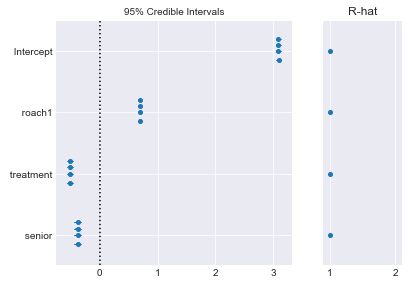

In [13]:
pm.forestplot(trace0, 
              varnames=['Intercept', 'roach1', 'treatment', 'senior']);

In [14]:
import loo
df_loo, pointwise = loo.loo(trace0, model=glmp)

Computed from 4000 by 262 log-likelihood matrix


In [15]:
df_k = loo.ks_summary(pointwise['ks'])

Pareto k diagnostic values:
             Count        Pct           _
(-Inf, 0.5]    240  91.603053      (good)
 (0.5, 0.7]      7   2.671756        (ok)
   (0.7, 1]      9   3.435115       (bad)
   (1, Inf)      6   2.290076  (very bad)


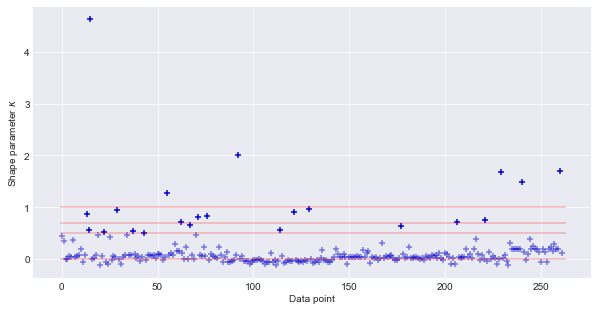

In [16]:
loo.plot_khat(pointwise['ks']);

In [17]:
with pm.Model() as glm1p:
    pm.glm.GLM.from_formula(
        'y ~ treatment + senior', data=roaches,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=5),
                    roach1=pm.Normal.dist(mu=0, sd=2.5),
                    treatment=pm.Normal.dist(mu=0, sd=2.5),
                    senior=pm.Normal.dist(mu=0, sd=2.5)),
        family=pm.glm.families.Poisson(),
        offset=np.log(roaches['exposure2'].values)
              )
    trace1 = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_log__, senior, treatment, Intercept]
100%|██████████| 2000/2000 [00:14<00:00, 136.77it/s]


In [18]:
with pm.Model() as glm2p:
    pm.glm.GLM.from_formula(
        'y ~ roach1 + senior', data=roaches,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=5),
                    roach1=pm.Normal.dist(mu=0, sd=2.5),
                    treatment=pm.Normal.dist(mu=0, sd=2.5),
                    senior=pm.Normal.dist(mu=0, sd=2.5)),
        family=pm.glm.families.Poisson(),
        offset=np.log(roaches['exposure2'].values)
              )
    trace2 = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_log__, senior, roach1, Intercept]
100%|██████████| 2000/2000 [00:12<00:00, 153.89it/s]


In [19]:
with pm.Model() as glm3p:
    pm.glm.GLM.from_formula(
        'y ~ roach1 + treatment', data=roaches,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=5),
                    roach1=pm.Normal.dist(mu=0, sd=2.5),
                    treatment=pm.Normal.dist(mu=0, sd=2.5),
                    senior=pm.Normal.dist(mu=0, sd=2.5)),
        family=pm.glm.families.Poisson(),
        offset=np.log(roaches['exposure2'].values)
              )
    trace3 = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_log__, treatment, roach1, Intercept]
100%|██████████| 2000/2000 [00:13<00:00, 143.39it/s]


In [20]:
df_loo1, pointwise1 = loo.loo(trace1, model=glm1p)
comp1 = loo.compare([pointwise1, pointwise])
comp1.round(1)

Computed from 4000 by 262 log-likelihood matrix


,elpd_diff,se
m1-m0,2224.1,614.6


In [21]:
df_loo2, pointwise2 = loo.loo(trace2, model=glm2p)
comp2 = loo.compare([pointwise2, pointwise])
comp2.round(1)

Computed from 4000 by 262 log-likelihood matrix


,elpd_diff,se
m1-m0,186.2,194.4


In [22]:
df_loo3, pointwise3 = loo.loo(trace3, model=glm3p)
comp3 = loo.compare([pointwise3, pointwise])
comp3.round(1)

Computed from 4000 by 262 log-likelihood matrix


,elpd_diff,se
m1-m0,40.8,108.6


Poster prediction check with statistics

100%|██████████| 500/500 [00:00<00:00, 1825.30it/s]


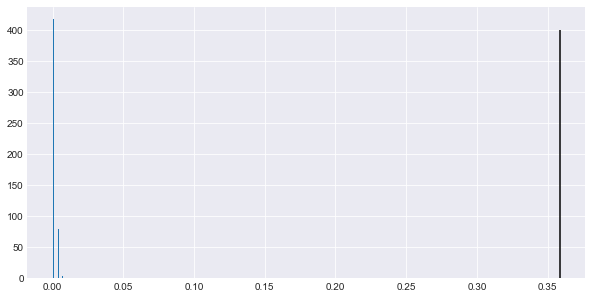

In [23]:
ppc = pm.sample_ppc(trace0, samples=500, model=glmp)

_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist((ppc['y']==0).mean(axis=1))
ax.vlines((roaches['y']==0).mean(), 0, 400);

In [25]:
neg_binom_fam = pm.glm.families.NegativeBinomial(
    priors = {'alpha': pm.Exponential.dist(lam=1)})
with pm.Model() as glmnb:
    pm.glm.GLM.from_formula(
        'y ~ roach1 + treatment + senior', data=roaches,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=5),
                    roach1=pm.Normal.dist(mu=0, sd=2.5),
                    treatment=pm.Normal.dist(mu=0, sd=2.5),
                    senior=pm.Normal.dist(mu=0, sd=2.5)),
        family=neg_binom_fam,
        offset=np.log(roaches['exposure2'].values)
              )
    trace0nb = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_log__, mu_log__, senior, treatment, roach1, Intercept]
100%|██████████| 2000/2000 [00:17<00:00, 117.49it/s]


In [26]:
pm.summary(trace0nb)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,2.846127,0.225578,0.004615,2.448809,3.309270,3146.046901,0.999816
roach1,1.315032,0.252744,0.004078,0.835160,1.810189,4337.912227,0.999639
treatment,-0.770531,0.243165,0.004567,-1.255323,-0.309588,3651.915165,0.999671
senior,-0.324772,0.262953,0.003704,-0.831529,0.206133,4931.256972,0.999665
mu,40.467568,208.342339,3.382993,0.004016,112.852659,3303.251136,1.000299
alpha,0.271384,0.025174,0.000329,0.223311,0.320797,4778.278053,0.999513


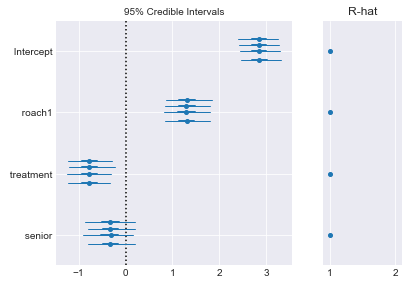

In [27]:
pm.forestplot(trace0nb, 
              varnames=['Intercept', 'roach1', 'treatment', 'senior']);

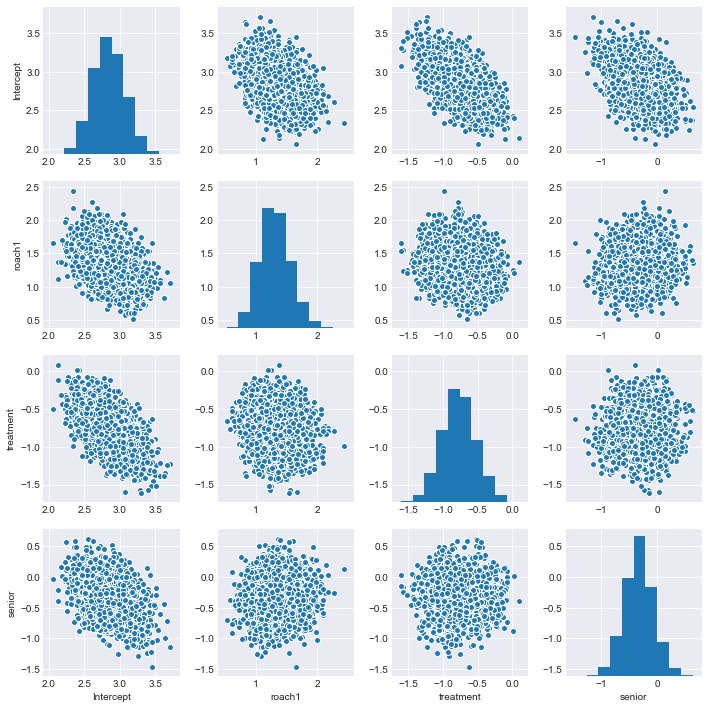

In [28]:
import seaborn as sns
tracedf0 = pm.trace_to_dataframe(trace0nb,
                                 varnames=['Intercept', 'roach1', 'treatment', 'senior'])
sns.pairplot(tracedf0);

In [29]:
loo_nb, pw_nb = loo.loo(trace0nb, model=glmnb)
loo_nb

Computed from 4000 by 262 log-likelihood matrix


,Estimate,SE
elpd_loo,-895.454989,37.600093
p_loo,6.441383,2.440580
looic,1790.909978,75.200185


In [30]:
df_nb = loo.ks_summary(pw_nb['ks'])

Pareto k diagnostic values:
             Count        Pct           _
(-Inf, 0.5]    260  99.236641      (good)
 (0.5, 0.7]      0   0.000000        (ok)
   (0.7, 1]      2   0.763359       (bad)
   (1, Inf)      0   0.000000  (very bad)


In [31]:
compnew = loo.compare([pw_nb, pointwise])
compnew.round(1)

,elpd_diff,se
m1-m0,-5346.0,706.1


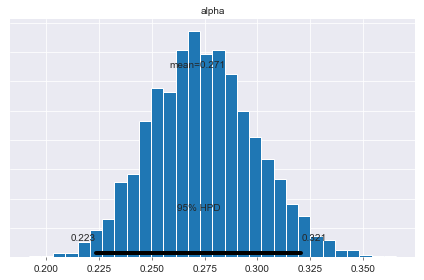

In [32]:
pm.plot_posterior(trace0nb, varnames=['alpha']);

100%|██████████| 500/500 [00:00<00:00, 619.25it/s]


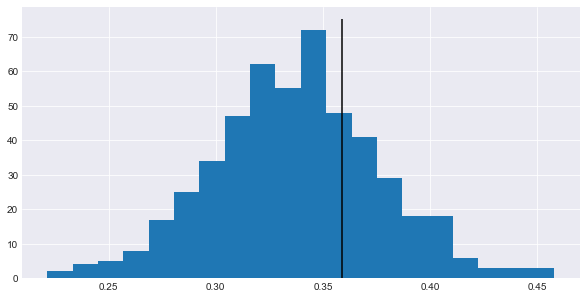

In [33]:
ppc = pm.sample_ppc(trace0nb, samples=500, model=glmnb)

_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist((ppc['y']==0).mean(axis=1), 20)
ax.vlines((roaches['y']==0).mean(), 0, 75);

In [34]:
with pm.Model() as glm1nb:
    pm.glm.GLM.from_formula(
        'y ~ treatment + senior', data=roaches,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=5),
                    roach1=pm.Normal.dist(mu=0, sd=2.5),
                    treatment=pm.Normal.dist(mu=0, sd=2.5),
                    senior=pm.Normal.dist(mu=0, sd=2.5)),
        family=neg_binom_fam,
        offset=np.log(roaches['exposure2'].values)
              )
    trace1nb = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_log__, mu_log__, senior, treatment, Intercept]
100%|██████████| 2000/2000 [00:17<00:00, 114.46it/s]


In [35]:
with pm.Model() as glm2nb:
    pm.glm.GLM.from_formula(
        'y ~ roach1 + senior', data=roaches,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=5),
                    roach1=pm.Normal.dist(mu=0, sd=2.5),
                    treatment=pm.Normal.dist(mu=0, sd=2.5),
                    senior=pm.Normal.dist(mu=0, sd=2.5)),
        family=neg_binom_fam,
        offset=np.log(roaches['exposure2'].values)
              )
    trace2nb = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_log__, mu_log__, senior, roach1, Intercept]
100%|██████████| 2000/2000 [00:11<00:00, 171.71it/s]


In [36]:
with pm.Model() as glm3nb:
    pm.glm.GLM.from_formula(
        'y ~ roach1 + treatment', data=roaches,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=5),
                    roach1=pm.Normal.dist(mu=0, sd=2.5),
                    treatment=pm.Normal.dist(mu=0, sd=2.5),
                    senior=pm.Normal.dist(mu=0, sd=2.5)),
        family=neg_binom_fam,
        offset=np.log(roaches['exposure2'].values)
              )
    trace3nb = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_log__, mu_log__, treatment, roach1, Intercept]
100%|██████████| 2000/2000 [00:12<00:00, 159.99it/s]


In [37]:
loo_nb1, pw_nb1 = loo.loo(trace1nb, model=glm1nb)
comp1_ = loo.compare([pw_nb1, pw_nb])
comp1_.round(1)

Computed from 4000 by 262 log-likelihood matrix


,elpd_diff,se
m1-m0,21.6,5.9


In [38]:
loo_nb2, pw_nb2 = loo.loo(trace2nb, model=glm2nb)
comp2_ = loo.compare([pw_nb2, pw_nb])
comp2_.round(1)

Computed from 4000 by 262 log-likelihood matrix


,elpd_diff,se
m1-m0,3.6,4.2


In [39]:
loo_nb3, pw_nb3 = loo.loo(trace3nb, model=glm3nb)
comp3_ = loo.compare([pw_nb3, pw_nb])
comp3_.round(1)

Computed from 4000 by 262 log-likelihood matrix


,elpd_diff,se
m1-m0,-1.3,2.7
